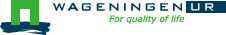



# Running PCSE/WOFOST with custom input data

This Jupyter notebook will show you how to read inputs from files.

Allard de Wit, March 2018

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;
  3. The `matplotlib` module for generating charts


## Introduction

For running PCSE/WOFOST (and PCSE models in general) with your own data sources you need three different types of inputs:

 1. Model parameters that parameterize the different model components. These parameters usually consist of a set of crop parameters (or multiple sets in case of crop rotations), a set of soil parameters and a set of site parameters. The latter provide ancillary parameters that are specific for a location, for example the initial amount of moisture in the soil.
 2. Driving variables represented by weather data which can be derived from various sources.
 3. Agromanagement actions which specify the farm activities that will take place on the field that is simulated by PCSE.

For this example we will run a simulation for sugar beet in Wageningen (Netherlands) and we will read the input data step by step from several different sources instead of using the pre-configured start_wofost() script. For the example we will assume that data files are in the directory `D:\temp\pcse_examples` and all the parameter files needed can be found by unpacking this [zip file](http://pcse.readthedocs.io/en/stable/_downloads/quickstart_part2.zip) .


## Importing the relevant modules


In [17]:
%matplotlib inline
import sys, os
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import pandas as pd

data_dir = r"D:\temp\pcse_examples"
import pcse
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 2.7.14 |Anaconda, Inc.| (default, Nov  8 2017, 13:40:13) [MSC v.1500 32 bit (Intel)] 
PCSE version: 5.3.1


## Reading model parameters
### Crop parameters

The crop parameters consist of parameter names and the corresponding parameter values that are needed to parameterize the components of the crop simulation model. These are crop-specific values regarding phenology, assimilation, respiration, biomass partitioning, etc. The parameter file for sugar beet is taken from the crop files in the WOFOST Control Centre.

As many crop models in Wageningen were written in FORTRAN, the crop parameters for many models in Wageningen are often provided in the CABO format that could be read with the TTUTIL FORTRAN library. This CABO format will be gradually phased out and PCSE will move to a new format based on YAML, see [here for an example](https://github.com/ajwdewit/WOFOST_crop_parameters/blob/master/wheat.yaml). However, PCSE tries to be backward compatible as much as possible and provides the `CABOFileReader` for reading parameter files in CABO format. The `CABOFileReader` returns a dictionary with the parameter name/value pairs:

In [3]:
from pcse.fileinput import CABOFileReader
cropfile = os.path.join(data_dir, 'sug0601.crop')
cropdata = CABOFileReader(cropfile)
print(cropdata)

** $Id: sug0601.cab 1.3 1997/09/25 14:07:02 LEM release $
** File SUG0601.CAB
** CROP DATA FILE for use with WOFOST Version 5.4, June 1992
**
** SUGAR BEET 601
** Regions : Germany, Northern and Central France, Netherlands, Belgium,
**           Luxembourg, UK, Ireland, Denmark
** Sowing date : between 1 and 10 April
** mean date of harvest : between 17 and 27 October
** Derived from SUCROS87 data set for sugar beet.
** Calibrated for use in WOFOST model at the Centre for Agrobiological
** Research (CABO-DLO) for the simulation of crop growth and yield on the
** basis of daily weather data.
** Purpose of application: Crop growth monitoring with agrometeorological
** model in the EC.
** Developed in the framework of JRC Agriculture Project Action 3.
------------------------------------
DTSMTB: [0.0, 0.0, 3.0, 0.0, 21.0, 18.0, 35.0, 18.0] <type 'list'>
CVR: 0.72 <type 'float'>
CVS: 0.69 <type 'float'>
EFFTB: [0.0, 0.45, 40.0, 0.45] <type 'list'>
CVO: 0.82 <type 'float'>
CVL: 0.72 <type '

### Soil parameters
The soildata dictionary provides the parameter name/value pairs related to the soil type and soil physical properties. The number of parameters is variable depending on the soil water balance type that is used for the simulation. For this example, we will use the water balance for freely draining soils and use the soil file for medium fine sand: `ec3.soil`. This file is also taken from the soil files in the [WOFOST Control Centre](http://www.wageningenur.nl/wofost).

In [6]:
soilfile = os.path.join(data_dir, 'ec3.soil')
soildata = CABOFileReader(soilfile)

### Site parameters

The site parameters provide ancillary parameters that are not related to the crop or the soil. Examples are the initial conditions of the water balance such as the initial soil moisture content (WAV) and the initial and maximum surface storage (SSI, SSMAX). Also the atmospheric $CO_{2}$ 
concentration is a typical site parameter. For the moment, we can define these parameters directly on the Python commandline as a simple python dictionary. However, it is more convenient to use the `WOFOST71SiteDataProvider` that documents the site parameters and provides sensible defaults:

In [5]:
from pcse.util import WOFOST71SiteDataProvider
sitedata = WOFOST71SiteDataProvider(WAV=100, CO2=360)
print(sitedata)

{'SMLIM': 0.4, 'NOTINF': 0, 'CO2': 360.0, 'SSI': 0.0, 'SSMAX': 0.0, 'IFUNRN': 0, 'WAV': 100.0}


### Packaging all parameters
Finally, we need to pack the different sets of parameters into one variable using the `ParameterProvider`. This is needed because PCSE expects one variable that contains all parameter values. Using this approach has the additional advantage that parameter value can be easily overridden in case of running multiple simulations with slightly different parameter values:

In [7]:
from pcse.base_classes import ParameterProvider
parameters = ParameterProvider(cropdata=cropdata, soildata=soildata, sitedata=sitedata)

## Agromanagement
The agromanagement inputs provide the start date of the agricultural campaign, the start_date/start_type of the crop simulation, the end_date/end_type of the crop simulation and the maximum duration of the crop simulation. The latter is included to avoid unrealistically long simulations for example as a results of a too high temperature sum requirement.

The agromanagement inputs are defined with a special syntax called [YAML](http://yaml.org/) which allows to easily create more complex structures which is needed for defining the agromanagement. The agromanagement file for sugar beet in Wageningen `sugarbeet_calendar.agro` can be read with the `YAMLAgroManagementReader`:

In [14]:
from pcse.fileinput import YAMLAgroManagementReader
agromanagement_file = os.path.join(data_dir, 'sugarbeet_calendar.agro')
agromanagement = YAMLAgroManagementReader(agromanagement_file)
print(agromanagement)

!!python/object/new:pcse.fileinput.yaml_agmt_loader.YAMLAgroManagementReader
listitems:
- 2000-01-01:
    CropCalendar:
      crop_end_date: 2000-10-20
      crop_end_type: harvest
      crop_name: sugar-beet
      crop_start_date: 2000-04-05
      crop_start_type: emergence
      max_duration: 300
      variety_name: sugar-beet-601
    StateEvents: null
    TimedEvents: null



## Daily weather observations
Daily weather variables are needed for running the simulation. There are several data providers in PCSE for reading weather data, see the section on [weather data providers](http://pcse.readthedocs.io/en/stable/reference_guide.html#weather-data-providers) to get an overview.

For this example we will use the weather data from the NASA Power database which provides global weather data with a spatial resolution of 1 degree (~100 km). We will retrieve the data from the Power database for the location of Wageningen. Note that it can take around 30 seconds to retrieve the weather data from the NASA Power server the first time:

In [12]:
from pcse.db import NASAPowerWeatherDataProvider
wdp = NASAPowerWeatherDataProvider(latitude=52, longitude=5)
print(wdp)


Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER Agroclimatology Daily Averaged Data
Dates (month/day/year): 01/01/1984 through 03/07/2018
Location: Latitude 52   Longitude 5
Location clarification: Integer values may indicate the lower left (south and west) corner of the one degree lat/lon region that includes the requested locations
Elevation (meters): Average for one degree lat/lon region = 5
Methodology Documentation:
*Vegetation type: "Airport": flat rough grass
----Site characteristics----
Elevation:    5.0
Latitude:  52.000
Longitude:  5.000
Data available for 1997-01-01 - 2015-10-31
Number of missing days: 53



## Importing, initializing and running a PCSE model

Internally, PCSE uses a simulation engine to run a crop simulation. This engine takes a configuration file that specifies the components for the crop, the soil and the agromanagement that need to be used for the simulation. So any PCSE model can be started by importing the engine and initializing it with a given configuration file and the corresponding parameters, weather data and agromanagement.

However, as many users of PCSE only need a particular configuration (for example the WOFOST model for potential production), preconfigured Engines are provided in `pcse.models`. For the sugarbeet example we will import the WOFOST model for water-limited simulation under freely draining soil conditions:

In [15]:
from pcse.models import Wofost71_WLP_FD
wofsim = Wofost71_WLP_FD(parameters, wdp, agromanagement)

We can then run the simulation and retrieve the time series of daily simulation output using the get_output() method on the WOFOST object. Finally, we convert the simulation reults to a pandas dataframe:

In [22]:
wofsim.run_till_terminate()
df_results = pd.DataFrame(wofsim.get_output())
df_results = df_results.set_index("day")
df_results.tail()

,DVS,LAI,RD,SM,TAGP,TRA,TWLV,TWRT,TWSO,TWST,WWLOW
day,,,,,,,,,,,
2000-10-16,2.201050,1.200832,80.0,0.239034,23557.982864,0.036234,3227.409768,2877.735493,16498.977589,3831.595507,19.122753
2000-10-17,2.207550,1.182712,80.0,0.245265,23557.982864,0.043473,3227.409768,2877.735493,16498.977589,3831.595507,19.621235
2000-10-18,2.213614,1.188421,80.0,0.244201,23615.065983,0.038306,3230.263924,2878.900454,16550.352395,3834.449663,19.536093
2000-10-19,2.218050,1.163961,80.0,0.250108,23629.737798,0.042180,3230.997515,2879.199879,16563.557029,3835.183254,20.008650
2000-10-20,2.223793,1.171007,80.0,0.249246,23700.199586,0.023517,3234.520604,2880.637875,16626.972638,3838.706343,19.939648


Finally, we can generate some figures of WOFOST variables such as the development (DVS), total biomass (TAGP), leaf area index (LAI) and root-zone soil moisture (SM) using the MatPlotLib plotting package:

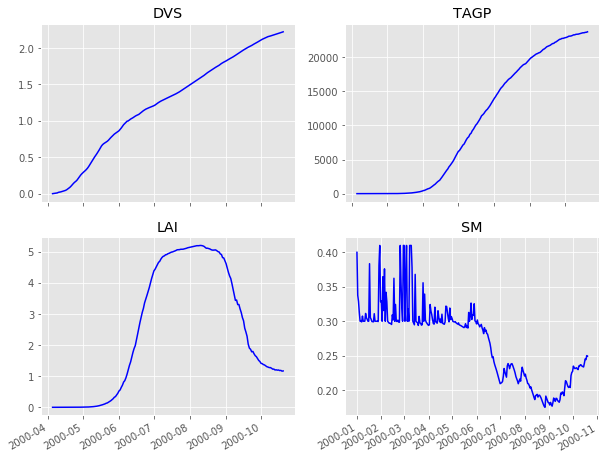

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
for var, ax in zip(["DVS", "TAGP", "LAI", "SM"], axes.flatten()):
    ax.plot_date(df_results.index, df_results[var], 'b-')
    ax.set_title(var)
fig.autofmt_xdate()